In [2]:
!unzip /content/drive/MyDrive/DDD_Dataset/driver-drowsiness-dataset-ddd.zip

Streaming output truncated to the last 5000 lines.
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0095.png

Epoch 0/14
----------
train Loss: 0.6129 Acc: 0.6662
val Loss: 0.5372 Acc: 0.7412

Epoch 1/14
----------
train Loss: 0.4722 Acc: 0.7770
val Loss: 0.3633 Acc: 0.8379

Epoch 2/14
----------
train Loss: 0.3068 Acc: 0.8735
val Loss: 0.2575 Acc: 0.8982

Epoch 3/14
----------
train Loss: 0.2137 Acc: 0.9165
val Loss: 0.1724 Acc: 0.9374

Epoch 4/14
----------
train Loss: 0.1682 Acc: 0.9377
val Loss: 0.1486 Acc: 0.9446

Epoch 5/14
----------
train Loss: 0.1374 Acc: 0.9499
val Loss: 0.1074 Acc: 0.9641

Epoch 6/14
----------
train Loss: 0.1136 Acc: 0.9588
val Loss: 0.0869 Acc: 0.9719

Epoch 7/14
----------
train Loss: 0.1012 Acc: 0.9639
val Loss: 0.0784 Acc: 0.9706

Epoch 8/14
----------
train Loss: 0.0848 Acc: 0.9709
val Loss: 0.0721 Acc: 0.9780

Epoch 9/14
----------
train Loss: 0.0825 Acc: 0.9717
val Loss: 0.0614 Acc: 0.9770

Epoch 10/14
----------
train Loss: 0.0724 Acc: 0.9747
val Loss: 0.0493 Acc: 0.9842

Epoch 11/14
----------
train Loss: 0.0648 Acc: 0.9782
val Loss: 0.0423 Acc: 0.9853

Ep

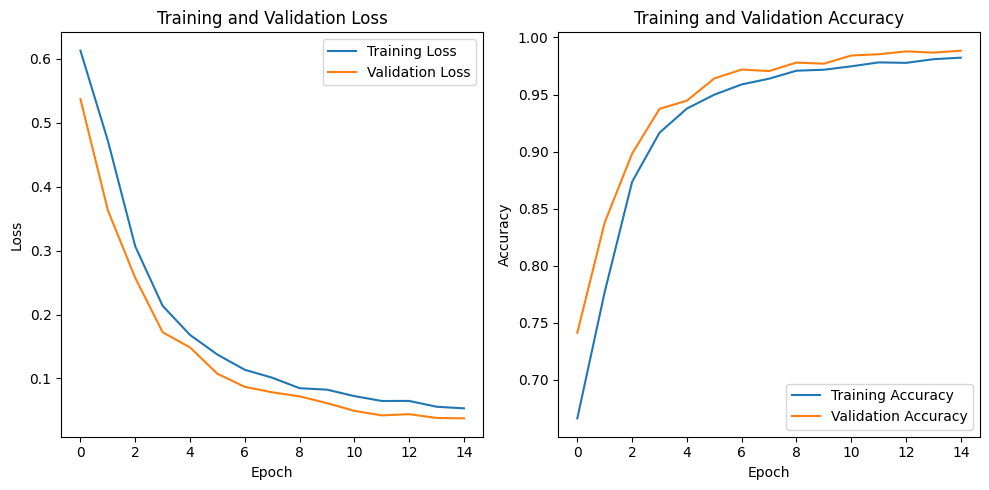

Test Accuracy: 0.9849


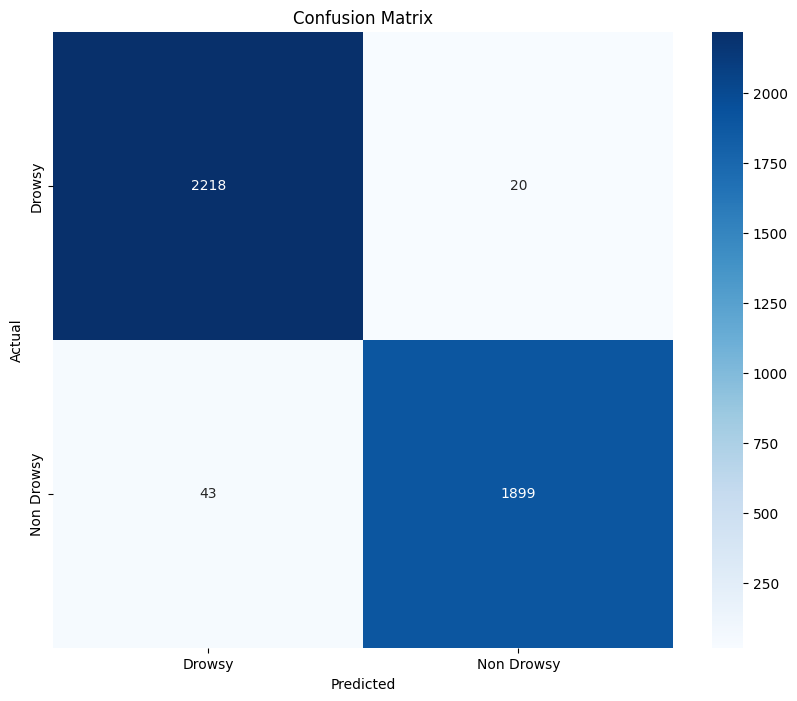

Classification Report
              precision    recall  f1-score   support

      Drowsy       0.98      0.99      0.99      2238
  Non Drowsy       0.99      0.98      0.98      1942

    accuracy                           0.98      4180
   macro avg       0.99      0.98      0.98      4180
weighted avg       0.98      0.98      0.98      4180



In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data augmentation and normalization for training, validation, and test
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/Driver Drowsiness Dataset (DDD)'

# Load dataset
dataset = datasets.ImageFolder(os.path.join(data_dir), data_transforms)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SimpleCNN(num_classes=len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, num_epochs=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

        print()

    return model, train_losses, val_losses, train_accs, val_accs

model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=15)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report')
print(report)


In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model.eval()

# Define the transformation for the input data
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_image(image):
    """Predict the class of an image using the trained model."""
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        return preds.item()

# Open a connection to the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to PIL format
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Predict the class
    prediction = predict_image(pil_image)
    label = class_names[prediction]

    # Display the prediction on the frame
    cv2.putText(frame, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Show the frame
    cv2.imshow('Driver Drowsiness Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close any OpenCV windows
cap.release()
cv2.destroyAllWindows()
